In [1]:
import numpy.matlib
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
j=complex(0,1)           # iota , sqrt of -1

c_light=3*10**8

epsilon=8.85*10**-12     # SI units, permitivitty of free space

#assuming no non-radiative losses and w_a=w

e_x = np.array([1,0.,0.]) # the vector for x polarized field


In [3]:
def Greens(m,l,k,r_1,r_2):
    '''Calculates the greens function G_{ml}(r_1,r_2) using eq S3'''
    if ((r_1[0]==r_2[0])and(r_1[1]==r_2[1])and(r_1[2]==r_2[2])):    #skip the same atom
            return 0
    else:
            r_vect=r_1-r_2 
            r=np.sqrt(np.sum(np.square(r_vect)))
        
    if m==l: # serves as kronecker delta
        t1=(1+ (j*k*r-1)/((k*r)**2))      
    else: 
        t1=0
    t2=(-1 + (3-3*k*r*j)/(k*r)**2)*r_vect[m]*r_vect[l]/r**2
    t3=(np.cos(k*r)+j*np.sin(k*r))*(t1+t2)/(4*np.pi*r)  #eq S3
    return t3

$$G_{ij}(k,\textbf{r}_1,\textbf{r}_2)=\frac{e^{ikr}}{4\pi r}\left[\left(1+\frac{ikr-1}{k^2r^2}\right)\delta_{ij}+\left(-1+\frac{3-3ikr}{k^2r^2}\right)\frac{r^ir^j}{r^2}\right]$$
where $\textbf{r}=\textbf{r}_1-\textbf{r}_2$, $r=\left|{\textbf{r}}\right|$ and $r^i=e_i.\textbf{r}$

In [4]:
def gaussian_beam(x,y,z,w_0,lamda,e_L,E_0_amp=1):
    '''returns the incident gaussian beam at the point (x,y,z)\
    given byy equation eq. S55 \
    For z=0, exp(1/R(z)) term has been set to 0\
    lamda is the wavelength of the beam\
    w_0 is the beam waist at the focal point\
    e_L is the polarization vector\
    E_0_amp is the amplitude '''
    #wave number k
    k = 2*np.pi/lamda
    
    #below constants are as defined in the paper eq. S56
    z_R = np.pi*w_0**2/lamda 
    w_z = w_0*np.sqrt(1+(z/z_R)**2)

    phi_z = np.arctan(z/z_R)

    #Rz tends to infinity as z tends to 0. Which is why this ifelse condition is required \
    #to explicitly set the term involving  1/R to zero
    if z == 0:
        R_z = 1e100
        theta=k*z - phi_z #theta is the coeff of the exponential form of the complex number 
    else:
        R_z = z*(1+(z_R/z)**2)
        #This is the coeff of i in the exponential. 
        theta = k*z - phi_z + k*(x**2+y**2)/(2*R_z)
    
    #Following are the magnitude, real part and imaginary part respectively of the electric field of incident light
    E_0 = (E_0_amp*(w_0/w_z)*np.exp(-1*(x**2+y**2)/(w_z**2))*(np.cos(theta)+j*np.sin(theta)))*e_L # eq S55

    return E_0 #the final incident beam at (x,y,z) 

Gaussian beam equation:

$$\textbf{E}_0\left(x',y',z'\right) = E_0\textbf{e}_L\frac{w_0}{w(z')}e^{ikz'}e^{-i\phi(z')}e^{-\frac{x'^2+y'^2}{w^2(z')}}e^{ik\frac{x'^2+y'^2}{2R(z')}}$$
    
with the parameters being,
    
$$w(z)=w_0\sqrt{1+\left(\frac{z}{z_R}\right)^2},   z_R=\frac{\pi w_0^2}{\lambda},    R\left(z\right)=z\left[1+\left(\frac{z_R}{z}\right)^2\right],    \phi \left(z\right) = \arctan\left(\frac{z'}{z_R}\right)$$

Plot the variation of the electric field of the beam  with z axis at x=0,y=0

In [50]:
class atomic_array:
    def __init__( self ,a, R):
        
# finding G
        self.a=a           
        self.R=R # the positions of all atoms
        self.n= len(self.R) # no. of atoms
        n=self.n
        
    def show_atomic_array(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        #ax.view_init(3*10**-7,2*10**-7,'x')
        ax.scatter3D(self.R[:,0],self.R[:,1],self.R[:,2],cmap="Greens")
        
    def find_E_at_atoms(self,ray):
        #n=self.n
        #self.w_0=w_0
        #ray.lamda=lamda
        #self.light=light
        #self.detunning_by_gamma=0
        #self.gamma_nr=gamma_nr
        #self.gamma=gamma
        #self.gamma_0=gamma+gamma_nr
        print(self.n)
        gamma_0=ray.gamma+ray.gamma_nr
        w_a= (2*np.pi*c_light/ray.lamda ) -  (ray.detuning) #   w-w_a =detuning
        lamda_a=2*np.pi*c_light/w_a
        self.alpha= ( - 3/(4*np.pi**2))*epsilon*(lamda_a**3)*((1/2)/(ray.detuning_by_gamma + j*ray.gamma_0/(ray.gamma*2))) # polarization of an atom
        self.E_0_at_atoms = np.zeros(shape=(self.n,3),dtype=np.complex_)
        self.G=np.empty(shape=(self.n,3,self.n,3),dtype=np.complex_)
#Calculating the G matrix to find the field at the atoms in n_1,3,n_2,3 form, where n_1 is index of r1, n_2 is index of r2
# this g is used in eq S54       

        print('finding G')   
        for r_1 in range(0,self.n):      
             for m in range(0,3):
                    for r_2 in range(0,self.n):
                        for l in range(0,3):
                            self.G[r_1,m,r_2,l]=Greens(m,l,ray.k,self.R[r_1],self.R[r_2])# using eq S3
        # Find E_0_at_atoms
        
         #position of atoms is at (x,y,0)
        #The order is as explained in the final cell of gaussian_beam
        
        print('fining E ')
        for i in range(0,self.n):
            self.E_0_at_atoms[i] = ray.light_function(self.R[i][0],self.R[i][1],self.R[i][2])
        # G is in 3n * 3n matrix  form  
        G_M=self.G.reshape(3*self.n,3*self.n)
# E_0_at_atoms is the incident electric field at atoms
        E_0_V=self.E_0_at_atoms.reshape(3*self.n,1) # reshape E_n so that it can be multiplied by a 3n*3n  matrix
# Calculating total electric fields at the atoms
        I_M=np.identity(3*self.n,dtype=np.complex_)
        INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*self.alpha/(epsilon*ray.lamda**2)*G_M)) # the inverse term in eq S54
        self.E_at_atoms_V=np.matmul(INVERSE_M,E_0_V) # eq S54 
        
        #self.E_at_atoms=E_at_atoms_V.reshape(self.n,3) 
        
    def T_R_coefficients(self,ray,x,y,dist_z):
        '''returns the transmission and reflection coefficients, respectively, by calculating fields at the points \
        (x,y,-dist_z) and (x,y,dist_z), dist_z must be positive '''
        if (dist_z<0):
            dist_z=-dist_z
        self.find_E_at_atoms(ray)
        incident_at_minus_z, reflected_at_minus_z, total_at_minus_z = self.E_at_r(ray,x,y,-dist_z)
        incident_at_plus_z, transmitted_at_plus_z, total_at_plus_z = self.E_at_r(ray,x,y,dist_z)
        
        self.R_coeff=((np.abs(reflected_at_minus_z[0]))**2 +(np.abs(reflected_at_minus_z[1]))**2+ (np.abs(reflected_at_minus_z[2]))**2)\
                 /((np.abs(incident_at_minus_z[0]))**2 +(np.abs(incident_at_minus_z[1]))**2+ (np.abs(incident_at_minus_z[2]))**2 )
        
        self.T_coeff=((np.abs(total_at_plus_z[0]))**2 +(np.abs(total_at_plus_z[1]))**2+ (np.abs(total_at_plus_z[2]))**2)\
                 /((np.abs(incident_at_minus_z[0]))**2 +(np.abs(incident_at_minus_z[1]))**2+ (np.abs(incident_at_minus_z[2]))**2 )
        return self.T_coeff, self.R_coeff
    
    def E_at_r(self,ray,x,y,z):
        '''Must call find_E_at_atoms() atleast once for a given beam before finding E at an arbitrary point
        
        returns the incident electric field, scattered electric field and total electric field at the point (x,y,z)\
        E_at_atoms_V is the field at the atoms'''
        #E_at_atoms_V=self.E_at_atoms_V
        
        
        Greens_at_r = np.zeros(shape=(3,self.n,3),dtype=np.complex_)
        E_0_at_r = ray.light_function(x,y,z)# incident electric field
  
        for i in range(0,3):
            for m in range(0,3):
                for atoms_index in range(0,self.n):
                    Greens_at_r[i,atoms_index,m]=Greens(i,m,ray.k,(x,y,z),self.R[atoms_index])
             
        Greens_at_r_M = Greens_at_r.reshape(3,3*self.n)
    # the scattered electric field
        Scattered_field = (4*(np.pi**2)*self.alpha/(epsilon*ray.lamda**2)) *np.matmul(Greens_at_r_M,self.E_at_atoms_V).reshape(3,)\
    #total electric field
        E_space = np.add(E_0_at_r , Scattered_field)
    
        return E_0_at_r, Scattered_field, E_space # incident field, scattered field, total field        
   

    def plot_elec_field(self,ray,x_find,y_find):
        self.find_E_at_atoms(ray)
        #x_find,y_find=0*self.a,self.a # the electric field is found in direction perpendicular to x_find,y_find in the atomic array's plane 

        perpendicular_direction=np.arange(-5,5+1/100,1/20) #z/lamda array i.e z=-5*lamda to 5#lamda

        E_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

        Scattered_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

        Incident_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

        for i in range(0,len(perpendicular_direction),1):
             Incident_perpendicular_to_array[i],Scattered_perpendicular_to_array[i], E_perpendicular_to_array[i]=self.E_at_r(ray,x_find,y_find,ray.lamda*perpendicular_direction[i])
        self.I=Incident_perpendicular_to_array 
        self.T=E_perpendicular_to_array
        self.S=Scattered_perpendicular_to_array
        
        plt.plot(perpendicular_direction,np.square(abs(self.T[:,0]/self.I[:,0]))) 
        plt.title('The square of absolute value of total electric field ')
        plt.xlabel('z/$\lambda$')
        plt.text(4,1.25,f'a/$\lambda={self.a/ray.lamda}$\n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)} $')
        plt.ylabel('$|E_{x}/E_0|^2$')
       # plt.ylim(-1,1)
        plt.show()
        
        plt.plot(perpendicular_direction,self.S[:,0].imag,'b--',label='imaginary part of scattered field',)
        plt.plot(perpendicular_direction,self.I[:,0].imag,color='red',label='imag part of incident field')

        plt.legend(bbox_to_anchor=(1,1))
        plt.title('Imaginary part')
        plt.xlabel('z/$\lambda$')
        plt.ylabel('$Im[E_{x}]$')
        plt.text(4,1.25,f'a/$\lambda={self.a/ray.lamda}$\n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)} $')
        plt.show()
        
        
        
        plt.plot(perpendicular_direction,self.S[:,0].real,'b--',label='real part of scattered field',)
        plt.plot(perpendicular_direction,self.I[:,0].real,color='red',label='real part of incident field')
        plt.legend(bbox_to_anchor=(1,1))
        plt.title('Real part')
        plt.text(4,1.25,f'a/$\lambda={a/ray.lamda}$\n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)} $')
        plt.xlabel('z/$\lambda$')
        plt.ylabel('$Re[E_{x}]$')
        plt.show()
        
        

In [51]:
class gaussian_ray:
    def __init__(self,w_0=1,lamda=1,e_L=np.array((1,0,0)),E_beam_amp=1,detuning=0,detuning_by_gamma=0,gamma_nr=0):
        self.w_0=w_0
        self.lamda=lamda
        self.k=2*np.pi/lamda
        self.e_L=e_L
        self.E_beam_amp=E_beam_amp
        self.detuning=detuning
        self.detuning_by_gamma=detuning_by_gamma
        self.gamma=1
        self.gamma_nr=gamma_nr
        self.gamma_0=self.gamma+self.gamma_nr
        
    def light_function(self,x,y,z):
        '''returns the incident gaussian beam at the point (x,y,z)\
        given by equation eq. S55 \
        For z=0, exp(1/R(z)) term has been set to 0\
        lamda is the wavelength of the beam\
        w_0 is the beam waist at the focal point\
        e_L is the polarization vector\
        E_0_amp is the amplitude '''
    #wave number k
    
        k = 2*np.pi/self.lamda
    
    #below constants are as defined in the paper eq. S56
        z_R = np.pi*self.w_0**2/self.lamda
        w_z = self.w_0*np.sqrt(1+(z/z_R)**2)

        phi_z = np.arctan(z/z_R)

    #Rz tends to infinity as z tends to 0. Which is why this ifelse condition is required \
    #to explicitly set the term involving  1/R to zero
        if z == 0:
            R_z = 1e100
            theta=k*z - phi_z #theta is the coeff of the exponential form of the complex number 
        else:
            R_z = z*(1+(z_R/z)**2)
        #This is the coeff of i in the exponential. 
            theta = k*z - phi_z + k*(x**2+y**2)/(2*R_z)
    
    #Following are the magnitude, real part and imaginary part respectively of the electric field of incident light
        E_0 = (self.E_beam_amp*(self.w_0/w_z)*np.exp(-1*(x**2+y**2)/(w_z**2))*(np.cos(theta)+j*np.sin(theta)))*self.e_L # eq S55
            
        return E_0 #the final incident beam at (x,y,z) 
     

In [99]:
class missing_atoms: 
    def __init__( self ,p, a, n_side):
        self.p = p
        self.a = a
        self.n_side = n_side

    def T_over10p(self,x,y,dist_z):
        
        N = n_side**2
        T = np.zeros(1)
        for i in range(1):     
            atoms = np.random.binomial(1, self.p, N)
            R1=[[0,0,0]]
            for j in range(0,N):
                if(atoms[j]==1):
                    R1=np.vstack([R1,[(-L/2+a*(j%n_side)),(L/2-a*int((j/n_side))),0]])
            R1 = np.delete(R1,0,0)
            n = len(R1[:,0])        
            
            arr1=atomic_array(a,R1)
            ray1=gaussian_ray(0.3*np.sqrt(n)*a,wavelength)
            T[i] = arr1.T_R_coefficients(ray1,x,y,dist_z)[0]
            print(arr1.T_R_coefficients(ray1,x,y,dist_z))
            
        return sum(T)/len(T)


In [103]:
wavelength=500*10**-9
a=0.2*wavelength
n_side=26         

p_x = np.arange(0.1,0.6,0.2)
T = np.zeros(len(p_x))

for i in range(len(p_x)):
    bla = missing_atoms(p_x[i],a,n_side)
    T[i] = bla.T_over10p(0,0,10*a)
print(T)

68
finding G
fining E 
68
finding G
fining E 
(0.6420765414380707, 0.04017997716384817)
220
finding G
fining E 
220
finding G
fining E 
(0.12858188404364085, 0.44393342424027704)
327
finding G
fining E 
327
finding G
fining E 
(0.15952499911767729, 0.5288602365408038)
[0.64207654 0.12858188 0.159525  ]


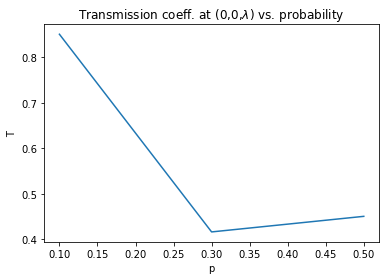

In [102]:

plt.plot(p_x, T) 
plt.title('Transmission coeff. at (0,0,$\lambda$) vs. probability ')
plt.xlabel('p')
plt.ylabel('T')
       # plt.ylim(-1,1)
plt.show()

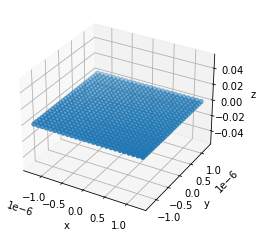

In [37]:

 
n=n_side**2           
L=(n_side-1)*a        
R1=np.zeros(shape=(n,3)) 

for i in range(0,n):
    R1[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)
k= 2*np.pi/wavelength   

arr1=atomic_array(a,R1)
arr1.show_atomic_array()

ray1=gaussian_ray(0.3*np.sqrt(n)*a,wavelength)



finding G
fining E 


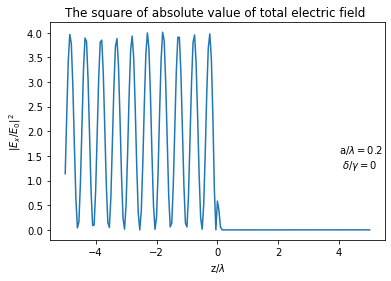

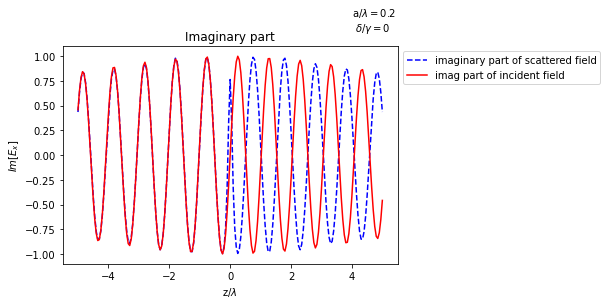

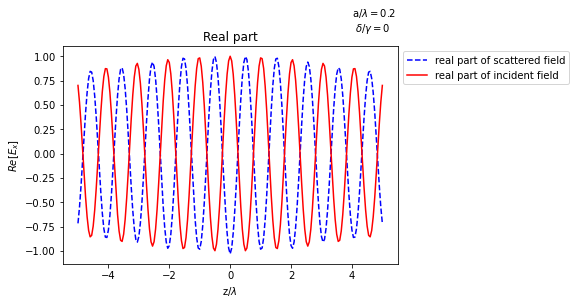

In [8]:
arr1.plot_elec_field(ray1,0,0)

In [9]:
arr1.T_R_coefficients(ray1,0,0,100*wavelength)

finding G
fining E 


(0.0010986215272525911, 0.9351302636160362)

The block below performs the task of finding the field at the atoms using eq S $54$


$$\overline{E} = E_i(\textbf{r}_n) = \left[1-4\pi^2\frac{\alpha}{\epsilon_0\lambda^3}\lambda\overline{\overline{\mathbb{G}}}\right]^{-1}\overline{E}_0$$

 The block below calculates the field at any point, using equation S5
$$E_i(\textbf{r}) = E_{0,i}(\textbf{r}) + 4\pi^2\frac{\alpha}{\epsilon_o\lambda^3}\sum_j\sum_n\lambda
    G_{ij}(k,\textbf{r},\textbf{r}_n)E_j(\textbf{r}_n)$$

This block find the field along the z-axis for a particulra x,y on the atomic plane

In [22]:
import csv
reader=csv.reader(open('CoopShift.csv'))
CoopShift=[]
for row in reader:
    CoopShift.append((float(row[0]),float(row[1])))
    

a_to_find_Delta=a
index=int(len(CoopShift)*(a_to_find_Delta/(len(CoopShift)*lamda/100)))
print(CoopShift[index][0])  

FileNotFoundError: [Errno 2] No such file or directory: 'CoopShift.csv'

In [23]:



detunning_by_gamma=CoopShift[index][0]

alpha_detuned= (- 3/(4*np.pi**2))*epsilon*(lamda_a**3)*((1/2)/(detunning_by_gamma + j*gamma_0/(gamma*2))) # polarization of an atom


G_M=G.reshape(3*n,3*n)

# E_0_at_atoms is the incident electric field at atoms
E_0_V=E_0_at_atoms.reshape(3*n,1) # reshape E_n so that it can be multiplied by a 3n*3n  matrix

# Calculating total electric fields at the atoms
I_M=np.identity(3*n,dtype=np.complex_)

INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*alpha_detuned/(epsilon*lamda**2)*G_M)) # the inverse term in eq S54

E_at_atoms_V=np.matmul(INVERSE_M,E_0_V) # eq S54 

E_at_atoms=E_at_atoms_V.reshape(n,3)

NameError: name 'CoopShift' is not defined

In [24]:
x_find,y_find=0*a,0*a # the electric field is found in direction perpendicular to x_find,y_find in the atomic array's plane 

perpendicular_direction=np.arange(-5,5+1/100,1/20) #z/lamda array i.e z=-5*lamda to 5#lamda

E_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

Scattered_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

Incident_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

for i in range(0,len(perpendicular_direction),1):
     Incident_perpendicular_to_array[i],Scattered_perpendicular_to_array[i], E_perpendicular_to_array[i]=E(x_find,y_find,lamda*perpendicular_direction[i],E_at_atoms_V)
I_detuned=Incident_perpendicular_to_array 
T_detuned=E_perpendicular_to_array
S_detuned=Scattered_perpendicular_to_array

NameError: name 'E' is not defined

In [25]:

plt.plot(perpendicular_direction,np.square(abs(T[:,0]/I[:,0])),color='red',label='$\delta=0$') 
plt.plot(perpendicular_direction,np.square(abs(T_detuned[:,0]/I_detuned[:,0])),color='blue',label=f'$\delta/\gamma={np.round(detunning_by_gamma,5)}$')
plt.title('The square of absolute value of total electric field ')
plt.xlabel('z/$\lambda$')
plt.ylabel('$|E_{x}/E_0|^2$')
plt.ylim(-0.1,4.1)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

NameError: name 'T' is not defined

In [26]:
plt.plot(perpendicular_direction,S[:,0].imag,'k--',label='imaginary part of scattered field',)
plt.plot(perpendicular_direction,I[:,0].imag,color='red',label='imag part of incident field')
plt.plot(perpendicular_direction,S_detuned[:,0].imag,'b--',label=f'imaginary part of scattered field $\delta/\gamma$={np.round(detunning_by_gamma,5)}',)
#plt.plot(perpendicular_direction,I_detuned[:,0].imag,color='blue',label=f'imag part of incident field $\delta/\gamma=${np.round(detunning_by_gamma,5)}')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Imaginary part')
plt.xlabel('z/$\lambda$')
plt.ylabel('$Im[E_{x}]$')
plt.show()
plt.plot(perpendicular_direction,S[:,0].imag,'k--',label='imaginary part of scattered field',)


NameError: name 'S' is not defined

In [27]:
plt.plot(perpendicular_direction,S[:,0].imag,'k--',label='imaginary part of scattered field',)
plt.plot(perpendicular_direction,I[:,0].imag,color='red',label='imag part of incident field')
plt.plot(perpendicular_direction,S_detuned[:,0].imag,'b--',label=f'imaginary part of scattered field $\delta/\gamma$={np.round(detunning_by_gamma,5)}',)
#plt.plot(perpendicular_direction,I_detuned[:,0].imag,color='blue',label=f'imag part of incident field $\delta/\gamma=${np.round(detunning_by_gamma,5)}')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Real part')
plt.xlabel('z/$\lambda$')
plt.ylabel('$Im[E_{x}]$')
plt.show()

NameError: name 'S' is not defined

In [28]:
y_level=0
x_axis=np.arange(-5-1/50,5+1/50,1/4)
z_axis=np.arange(-5-1/50,5+1/50,1/4)
E_grid=np.zeros(shape=(len(x_axis),len(z_axis),3,3),dtype=np.complex_)

for i in range(0,len(x_axis)):
    for l in range(0,len(z_axis)):
            E_grid[i,l,0],E_grid[i,l,1],E_grid[i,l,2]=E(x_axis[i]*lamda,y_level,z_axis[l]*lamda,E_at_atoms_V)

# E_grid stores the values at the point in the format (x,z,field,component)
#field runs from 0 to 2, 0 is the incident field, 1 is the scattered field, 2 is the total field
#component refers  to the x,y,z component of a particular field at a particular point

NameError: name 'E' is not defined

C:\Users\91939\anaconda3\lib\site-packages\numpy\ma\core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


NameError: name 'lamda' is not defined

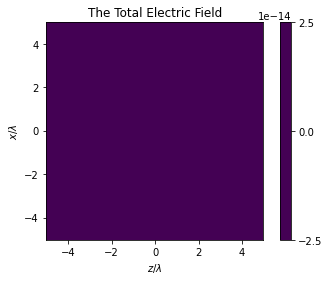

In [29]:
h = plt.contourf(z_axis,x_axis,(E_grid[:,:,2,0]))
plt.axis('scaled')
plt.title('The Total Electric Field')
plt.xlabel('$z/\lambda$')
plt.ylabel('$x/\lambda$')
plt.colorbar()
plt.clim(0,1)
plt.text(2,2.2,f'$a/ \lambda$  = {(a/lamda)}')
plt.show()